In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time 
import csv
import os
import scipy.stats as st
from pprint import pprint
from pandas import json_normalize
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#Data import of cases and deaths over time in the US and creating appropriate dataframes which highlights Top 10

# import csv file that is a breakdown of cases and deaths per day by state and county
df = pd.read_csv("CSV Folder/us-counties.csv.txt")

#group by state and date so that data is no longer at the county level, but at the state level
state_df = df.groupby(["state","date"])

#Create a data frame that has total cases by date by state
cases = state_df["cases"].sum()
workable_df = pd.DataFrame(cases)
workable_df = workable_df.reset_index()

#get the data for deaths per state per day into a series format to add to the cases dataframe
deaths = state_df["deaths"].sum()
death=pd.DataFrame(deaths)
work_death=death.reset_index()
DEAD = work_death["deaths"]

# Add Deaths column to the cases dataframe
workable_df["Deaths"]=DEAD

#Create final dataframe with just the columns we are interested in
final_df = workable_df[["date","state","cases","Deaths"]]

#Sort final df by date and re-index
final_df = final_df.sort_values("date")
final_df = final_df.reset_index(drop = True)

#Create Data Frame to display increase in cases over time of top 10 States in total current cases
cases=final_df.pivot( index="date",columns="state",values = "cases")
cases = cases.fillna(0)
top_cases =cases[["New York", "New Jersey","Massachusetts","California","Illinois","Pennsylvania","Michigan","Florida","Connecticut","Louisiana"]]

#Create Data Frame to display increase in deaths over time of top 10 States in total current deaths
death_df = final_df[final_df["Deaths"]>0]
death_plot = death_df.pivot( index="date",columns="state",values = "Deaths")
top_deaths = death_plot[["New York", "New Jersey","Massachusetts","California","Illinois","Pennsylvania","Michigan","Florida","Connecticut","Louisiana"]]

In [3]:
#Hospital Dataframe

#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)
hospital_data["num_icu_be"].fillna(0, inplace = True)
hospital_data["bed_utiliz"].fillna(0, inplace = True)

hospital_data["num_licens"].replace("****",0,inplace = True)
hospital_data["num_staffe"].replace("****",0,inplace = True)
hospital_data['num_licens']=hospital_data['num_licens'].astype(int)
hospital_data['num_staffe']=hospital_data['num_staffe'].astype(int)


#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].sum())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].sum()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].sum()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].sum()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].sum()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)

state_hospital_data.head()

,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized
state_name,,,,,
Alabama,120,18628,14974,1105.0,51.338370
Alaska,28,1760,1542,106.0,8.750062
Arizona,126,17163,15379,1263.0,55.551942
Arkansas,106,12869,9990,667.0,43.539306
California,466,85161,80802,6925.0,216.716364


In [4]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,10,11,24,18,12,21]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,6026,46863,NaN,52889,NaN,NaN,209,120,18628,14974,1105.0,51.338370,48,48,45,2,-15
1,Alaska,339,11942,NaN,12281,208.0,36.0,9,28,1760,1542,106.0,8.750062,3,2,11,40,11
2,Arizona,6045,54669,NaN,60714,1313.0,639.0,266,126,17163,15379,1263.0,55.551942,39,36,46,19,-1
3,Arkansas,2741,32837,NaN,35578,929.0,101.0,45,106,12869,9990,667.0,43.539306,46,45,49,5,1
4,California,39254,454919,NaN,494173,NaN,4880.0,1562,466,85161,80802,6925.0,216.716364,18,15,44,16,-17


United States Cases and Deaths Breakdown

C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


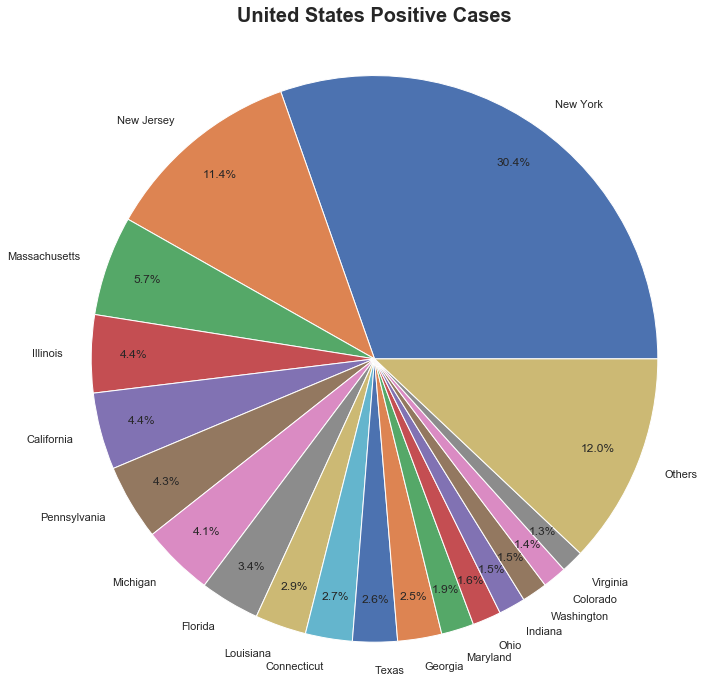

In [5]:
#Sequoyah's Circle Graph of Cases in US broken down by State

#comb2_df.sort_values("Positive", ascending = False,inplace = True)
comb2_df["Percent of Cases in US"]=round(comb2_df["Positive"]/comb2_df["Positive"].sum()*100,2)
comb2_df.reset_index(drop = True)
CasesbyStatePie = comb2_df[comb2_df["Percent of Cases in US"]>1]
CasesbyStatePie.sort_values("Positive", inplace = True, ascending = False)
USCases = comb2_df["Positive"].sum()
PercentTop = CasesbyStatePie["Percent of Cases in US"].sum()
PercentOther = (100 - float(PercentTop))
OtherCases = USCases - CasesbyStatePie["Positive"].sum()
Cases_Chart = CasesbyStatePie.append({"State":"Others","Positive":OtherCases,"Percent of Cases in US":PercentOther}, ignore_index = True)

#Sequoyah's Pie Chart 
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(Cases_Chart['Positive'], labels=Cases_Chart['State'], shadow=False, pctdistance=0.85, 
         autopct='%1.1f%%')
plt.axis('equal')
plt.title("United States Positive Cases",fontdict ={'fontsize': 20,
        'fontweight' : 700})# View the plot
plt.tight_layout()
plt.savefig("PNG Folder/United States Positive Cases.png") 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

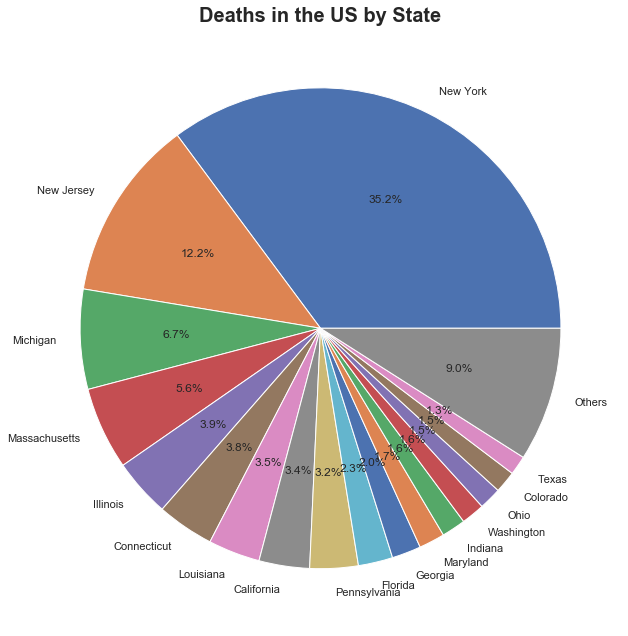

In [6]:
#Jimmy's Creation of new datframe for deaths circle graph and chart

#limit df to specific columns of interest
deathsbyState = comb2_df.loc[:,["State","Total Deaths"]]
#sort values so that in pie chart it goes from highest to lowest
deathsbyState.sort_values("Total Deaths", ascending = False,inplace = True)
#create an extra column to see percentages so that I can lump very small percentages into an other category
deathsbyState["Percent of Deaths in US"]=round(deathsbyState["Total Deaths"]/deathsbyState["Total Deaths"].sum()*100,2)
#reset index post sort
deathsbyState.reset_index(drop = True)
#Creating a variable to store all US deaths
USDeaths = deathsbyState["Total Deaths"].sum()
#limiting dataframe to only states accounting for at least 1% of the deaths in the US
deathsbyStatePie = deathsbyState[deathsbyState["Percent of Deaths in US"]>1]
#Finding the sum of the percents in the new df to get percent of those excluded for other category
PercentTop = deathsbyStatePie["Percent of Deaths in US"].sum()
#Calculating Percent of other category
PercentOther = (100 - float(PercentTop))
#Finding the deaths for the other category
OtherDeaths = USDeaths - deathsbyStatePie["Total Deaths"].sum()
#Inserting other row so the whole pie represents all US deaths
DeathsCircleChart = deathsbyStatePie.append({"State":"Others","Total Deaths":OtherDeaths,"Percent of Deaths in US":PercentOther}, ignore_index = True)

#Plotting storing and showing Pie Chart
labels = DeathsCircleChart["State"]
sizes = DeathsCircleChart ["Total Deaths"]
fig1, ax1 = plt.subplots(figsize=(9, 9))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')

plt.title("Deaths in the US by State",fontdict ={'fontsize': 20,
        'fontweight' : 700})

plt.tight_layout()
plt.savefig("PNG Folder/DeathPie.png")
plt.show

The New York and New Jersey region are dominating.  The Northeast is dominating a large chunk of the deaths in the US.  State deaths by region.

<function matplotlib.pyplot.show(*args, **kw)>

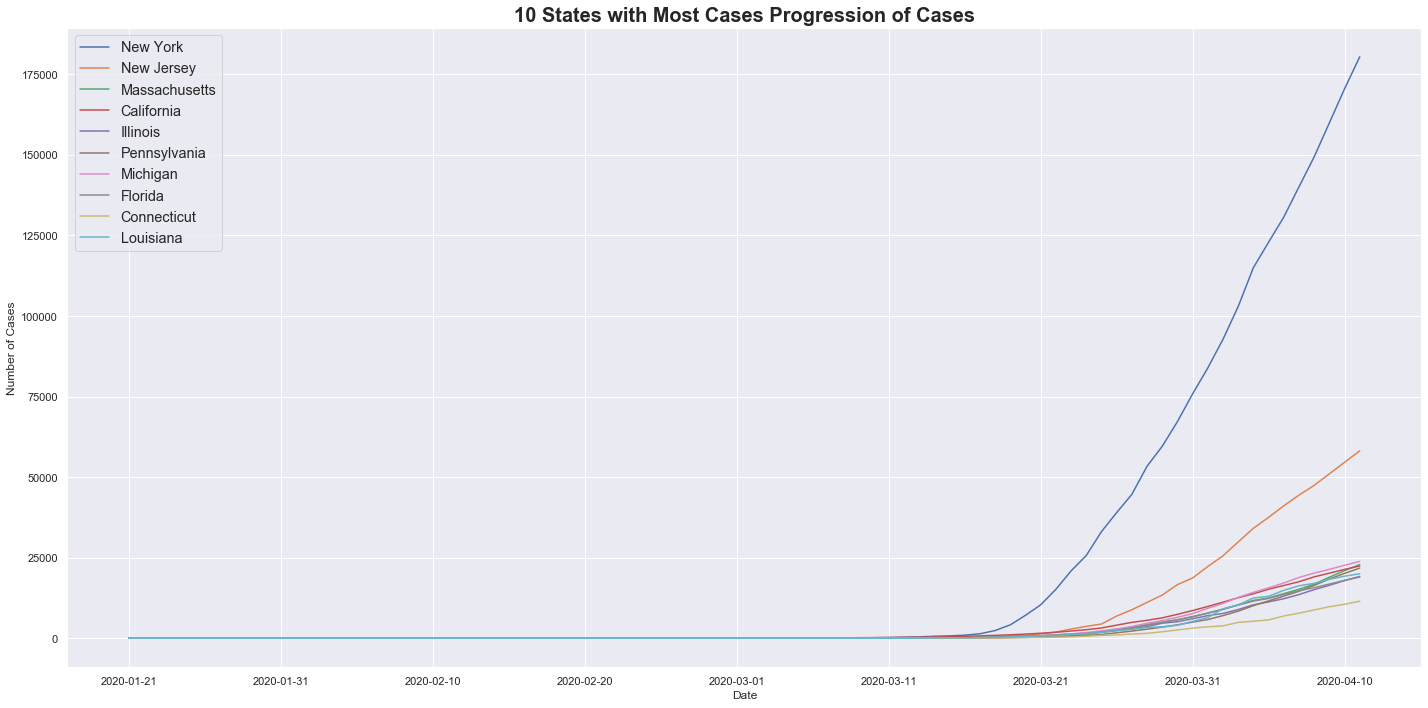

In [7]:
#Jimmy's line plot of US Cases over time (10 States with the most cases)

top_cases.plot.line(figsize = (20,10))
plt.legend(loc = 'upper left',fontsize ="large")
plt.title("10 States with Most Cases Progression of Cases",fontdict ={'fontsize': 20,
        'fontweight' : 700})
plt.ylabel("Number of Cases")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("PNG Folder/CaseOverTime.png")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

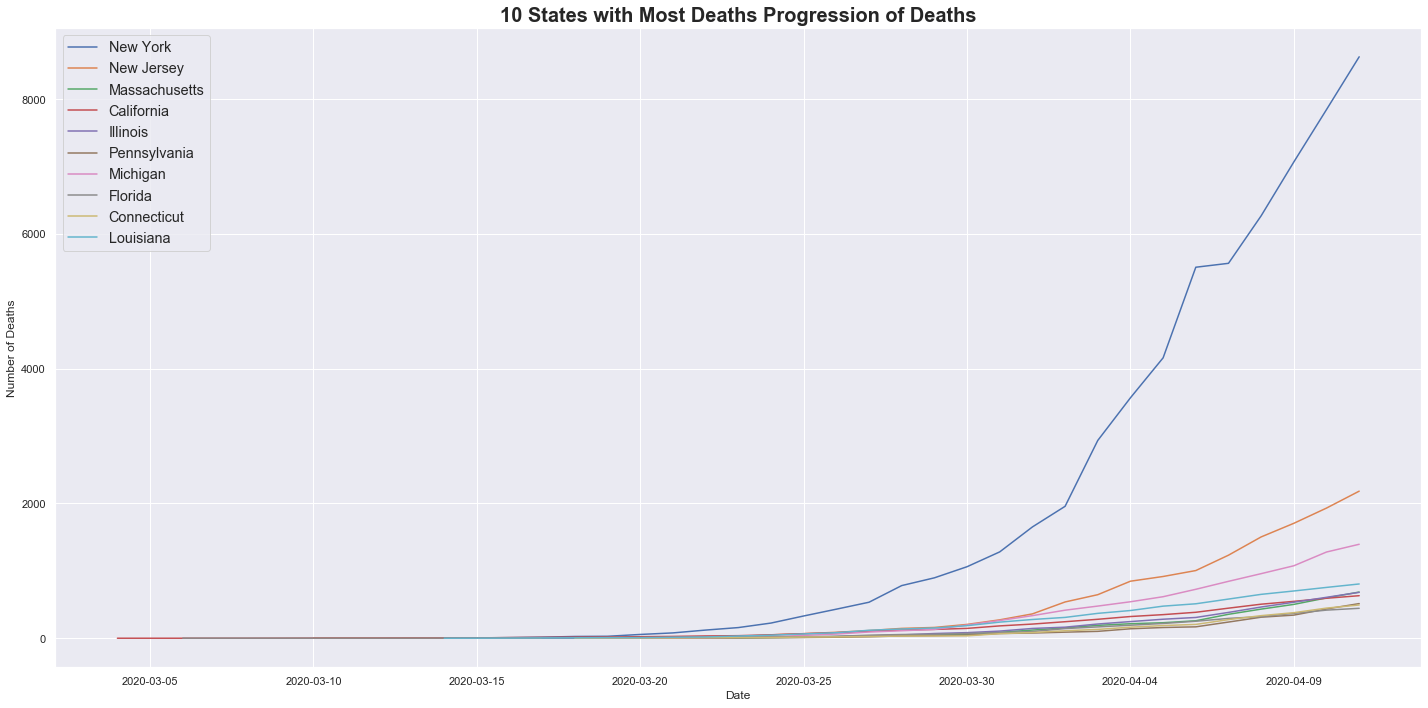

In [8]:
#Jimmy's line plot of US Deaths over time (10 States with the most cases)

top_deaths.plot.line(figsize = (20,10))
plt.legend(loc = 'upper left',fontsize ="large")
plt.title("10 States with Most Deaths Progression of Deaths",fontdict ={'fontsize': 20,
        'fontweight' : 700})
plt.ylabel("Number of Deaths")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("PNG Folder/DeathsOverTime.png")
plt.show

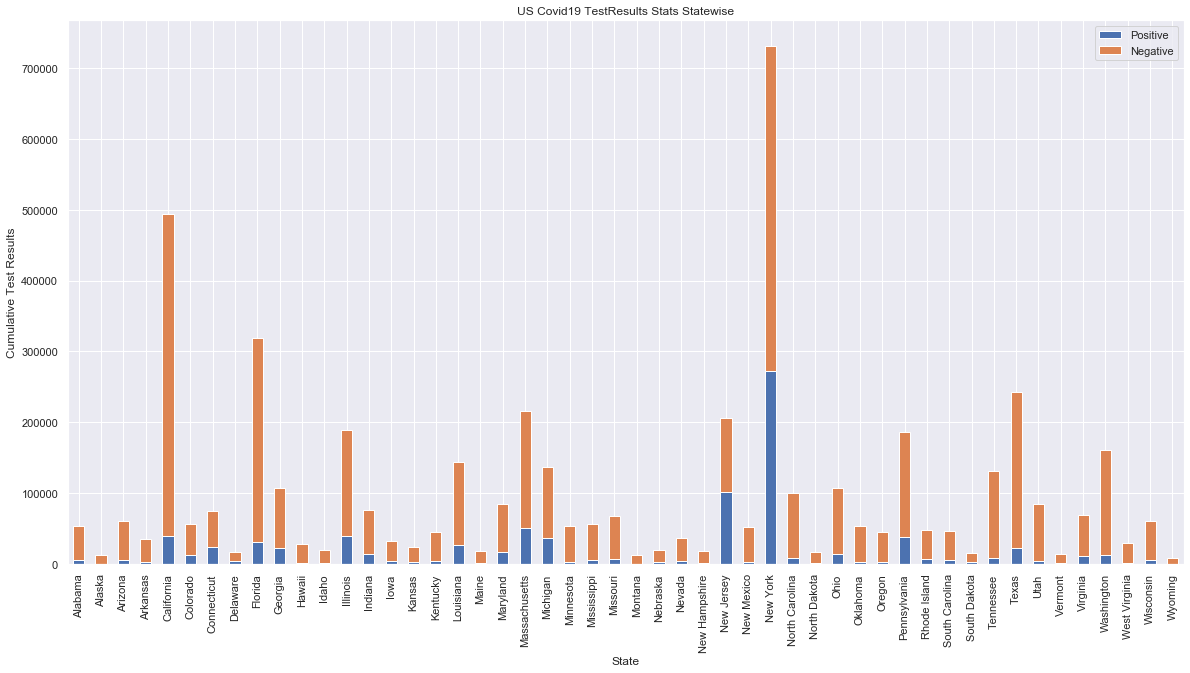

<Figure size 432x288 with 0 Axes>

In [9]:
#Shweta Stacked Bar of Cases and Deaths
# Filter the DataFrame down only to those columns to chart
bar_chart_df = comb2_df[["State","Positive","Negative"]]

# Set the index to be "State" so they will be used as labels
bar_chart_df = bar_chart_df.set_index("State")

# Use DataFrame.plot() in order to create a bar chart of the data
bar_chart_df.plot(kind="bar", figsize=(20,10), stacked=True,title = 'US Covid19 TestResults Stats Statewise')

# Display the chart
plt.ylabel("Cumulative Test Results")
plt.show()
plt.tight_layout()

# Save the bar chart
plt.savefig("PNG Folder/COVID19 Statewise TestResults Stacked Bar Chart.png")

The correlation between Total Tested and Total Deaths is 0.81
The equation of the regression line is: y = 0.02x + -544.84
The r-squared is: 0.807371108037154


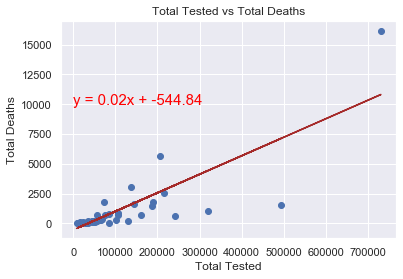

In [10]:
#Shweta Comparing Total Tested to Cases

#Filter the DataFrame down only to those columns to chart
scatter_chart_df = comb2_df[["State","Total Tested","Total Deaths"]]

# Set the index to be "State" so they will be used as labels
scatter_chart_df = scatter_chart_df.set_index("State")

#CORRELATION 
correlation=round(st.pearsonr(scatter_chart_df['Total Tested'],scatter_chart_df['Total Deaths'])[0],2)
print(f"The correlation between Total Tested and Total Deaths is {correlation}")

#REGRESSION
linear_regression_model=st.linregress(scatter_chart_df['Total Tested'],scatter_chart_df['Total Deaths'])

#Use the values of slope and intercept calculated above into the y=mx+b equation

slope=0.015544870610129788
intercept=-544.8409935520588

y = scatter_chart_df['Total Tested']*slope+intercept
plt.scatter(scatter_chart_df['Total Tested'],scatter_chart_df['Total Deaths'])
plt.plot(scatter_chart_df['Total Tested'],y,color="brown")
plt.xlabel('Total Tested')
plt.ylabel('Total Deaths')

line_equation = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
plt.annotate(line_equation,(20,10000),fontsize=15,color="red")


print(f"The equation of the regression line is: {line_equation}")
print(f"The r-squared is: 0.807371108037154")
plt.title('Total Tested vs Total Deaths')
plt.savefig("PNG Folder/COVID19 Linear Regression Total Tested vs Total Deaths.png")
plt.show()

In [11]:
#Jimmy Read in the Poverty Data File and Population Data File
df = pd.read_csv("CSV Folder/Poverty by state 2018.csv")
pop_df = pd.read_csv("CSV Folder/SCPRC-EST2019-18+POP-RES.csv")

#Select and rename columns of interest for merging
df.rename( columns={'Unnamed: 0':'State'}, inplace=True )
pop_df= pop_df[["NAME", "POPESTIMATE2019","POPEST18PLUS2019","PCNT_POPEST18PLUS"]]
pop_df = pop_df.rename(columns = {"NAME": "State","POPESTIMATE2019":"2019 Pop Est","POPEST18PLUS2019":"2019 18+","PCNT_POPEST18PLUS":"Percent 18+"})

#Merge the poverty and population df's and then merge with the state tests_df
poverty_df = pop_df.merge(df,how = 'inner',on = "State")
pov_death = tests_df.merge(poverty_df,how = 'inner', on = "State")

#Sort df by percent in poverty
pov_death.sort_values("Percent in Poverty (All)", ascending = False).head()
bins = (0,10,11,12,13,14,15,16,17,20)
labels = ("< 10","10-10.99","11-11.99","12-12.99","13-13.99","14-14.99","15-15.99","16-16.99","> 17")
pov_death["Poverty Groups"] = pd.cut(x = pov_death["Percent in Poverty (All)"], bins = bins, labels = labels)
pov_death.rename(columns = {"death":"Deaths","positive":"Cases","negative":"Negative Tests","totalTestResults":"Total Tests"},inplace=True)

#Incorporate a stay at home grade into the dataframe
grades = pd.read_csv("CSV Folder/StayatHomeGrades.txt")
pov_death = pov_death.merge(grades, how = 'inner', on = "State" )
#pov_death.drop(columns = ["Grade_x","Grade_y"], inplace = True)

#Store a grade df for easy reference that is sorted for visual reasons
grade = pov_death.sort_values("Grade", ascending = False)


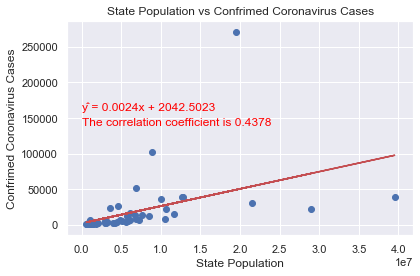

In [12]:
x_values = pov_death['2019 Pop Est']
y_values = pov_death['Cases']
#run linear regression and store key values
slope, intercept, r_value, p_value, std_err = st.linregress(pov_death['2019 Pop Est'],pov_death['Cases'])

#generate predicted y values based on regression model
regress_values = x_values * slope + intercept

#store linear regression equation and correlation coefficient
line_eq = "ŷ = " + str(round(slope,4)) + "x + " + str(round(intercept,4))
corr_coef = "The correlation coefficient is " + str(round(r_value,4))

#plot regression line
plt.plot(x_values, regress_values, "r-")

#plot regression equation and correlation coefficient on the graph
plt.annotate(line_eq, (0,160000),fontsize = 12, color = 'red')
plt.annotate(corr_coef,(0,140000),fontsize = 12, color = 'red')
#plt.annotate("New York", (20000000,14000),fontsize =12, color = 'red')
#plt.annotate("California", (35000000,2000),fontsize =12, color = 'red')
#plt.annotate("New Jersey", (5000000,6000),fontsize =12, color = 'red')

#Create scatter plot and add title, x-labels, and y-labels
plt.scatter(x_values, y_values)
plt.title("State Population vs Confrimed Coronavirus Cases")
plt.xlabel('State Population')
plt.ylabel('Confrimed Coronavirus Cases')
plt.tight_layout()
plt.savefig("PNG Folder/PopvsCases.png")
plt.show()

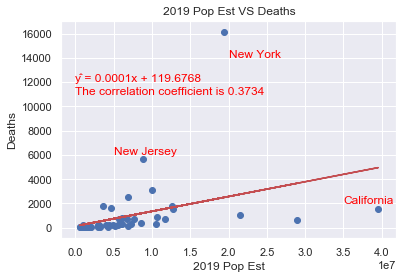

In [13]:
x_values = pov_death['2019 Pop Est']
y_values = pov_death['Deaths']
#run linear regression and store key values
slope, intercept, r_value, p_value, std_err = st.linregress(pov_death['2019 Pop Est'],pov_death['Deaths'])

#generate predicted y values based on regression model
regress_values = x_values * slope + intercept

#store linear regression equation and correlation coefficient
line_eq = "ŷ = " + str(round(slope,4)) + "x + " + str(round(intercept,4))
corr_coef = "The correlation coefficient is " + str(round(r_value,4))

#plot regression line
plt.plot(x_values, regress_values, "r-")

#plot regression equation and correlation coefficient on the graph
plt.annotate(line_eq, (0,12000),fontsize = 12, color = 'red')
plt.annotate(corr_coef,(0,11000),fontsize = 12, color = 'red')
plt.annotate("New York", (20000000,14000),fontsize =12, color = 'red')
plt.annotate("California", (35000000,2000),fontsize =12, color = 'red')
plt.annotate("New Jersey", (5000000,6000),fontsize =12, color = 'red')

#Create scatter plot and add title, x-labels, and y-labels
plt.scatter(x_values, y_values)
plt.title("2019 Pop Est VS Deaths")
plt.xlabel('2019 Pop Est')
plt.ylabel('Deaths')
plt.savefig("PNG Folder/PopvsDeath.png")
plt.show()

The r-squared is: 0.1882552030353843


C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

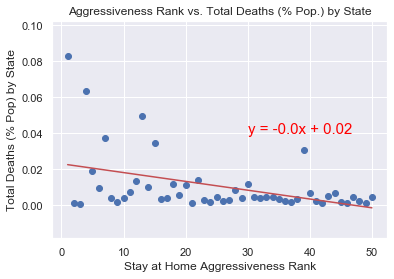

In [14]:
#Liz format dataframe to run a scatter plot on Aggressiveness Rank and Total Death
rankpop_df = comb2_df.merge(pop_df,how = 'left',on = "State")
rankpop_df2 = rankpop_df[["State","2019 Pop Est","Overall Rank","Total Deaths"]]
rankpop_df2.sort_values("Overall Rank", inplace=True)
rankpop_df2.reset_index(inplace=True,drop=True)
x_values = range(1,51)
y_values = rankpop_df2["Total Deaths"]/rankpop_df2["2019 Pop Est"]*100
labels =rankpop_df2["State"]

plt.scatter(x_values,y_values)
plt.xlabel("Stay at Home Aggressiveness Rank")
plt.ylabel("Total Deaths (% Pop) by State")
plt.title("Aggressiveness Rank vs. Total Deaths (% Pop.) by State")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,.04),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("PNG Folder/liz_stateaggressive_scatter_final.png")
plt.show

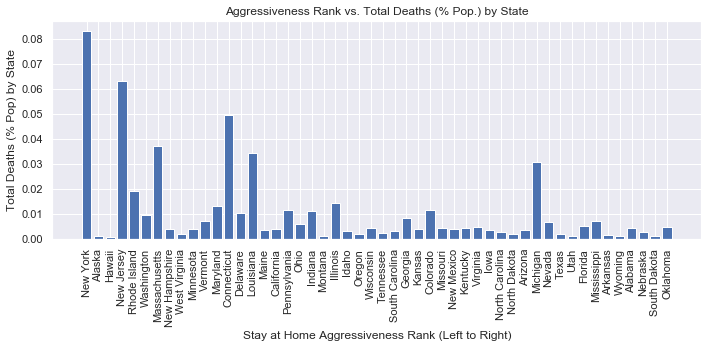

In [15]:
#bar graph displaying the same info
labels =rankpop_df2["State"]
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(x_values,y_values,align="center")
plt.xticks(x_values,labels, rotation='vertical')
plt.xlabel("Stay at Home Aggressiveness Rank (Left to Right)")
plt.ylabel("Total Deaths (% Pop) by State")
plt.title("Aggressiveness Rank vs. Total Deaths (% Pop.) by State")
plt.tight_layout()
plt.savefig("PNG Folder/liz_stateaggressive_bar_final.png")
plt.show()

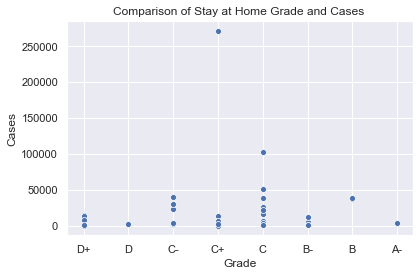

In [16]:
#Used seasborn to do a scatter plot of Stay at home grade vs number of cases
ax= sns.scatterplot(x="Grade", y ="Cases",data= grade).set_title("Comparison of Stay at Home Grade and Cases ")
plt.tight_layout()
plt.savefig("PNG Folder/StayatHome.png")

The r-squared is: 0.09619002207087893


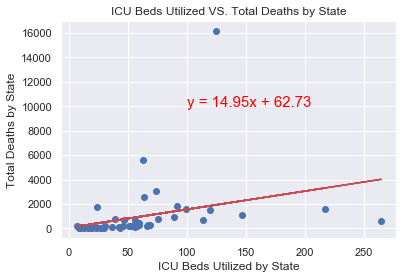

In [17]:
#Liz's scatter plot looking at Percent of ICU Beds Utilized vs Total Deaths
x_values = comb2_df["ICU Beds Utilized"]
y_values = comb2_df["Total Deaths"]
plt.scatter(x_values,y_values)
plt.xlabel("ICU Beds Utilized by State")
plt.ylabel("Total Deaths by State")
plt.title("ICU Beds Utilized VS. Total Deaths by State")


(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(100,10000),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("PNG Folder/liz_bedsutilizedvsdeaths_scatter_final.png")

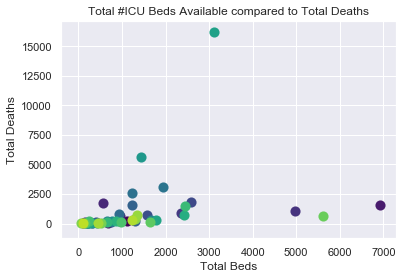

In [18]:
#Sequoyah's Scatter plot
import matplotlib.cm as cm
import matplotlib.colors as colors


fig, ax = plt.subplots()



colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(comb2_df['State']))]

for i,c in enumerate(colorlist):

    x = comb2_df['ICU Beds Available'][i]
    y = comb2_df['Total Deaths'][i]
    l = comb2_df['State'][i]

    ax.scatter(x , y , label=l, s=100, linewidth=0.1, c=c)      


#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Total #ICU Beds Available compared to Total Deaths')
ax.set_xlabel('Total Beds')
ax.set_ylabel('Total Deaths')

plt.savefig("PNG Folder/Total #ICU beds compared to Total Deaths.png") 
plt.show()

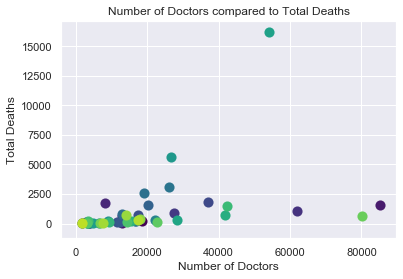

In [19]:
#Sequoyah's Scatter plot
fig, ax1 = plt.subplots()



colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(comb2_df['State']))]

for i,c in enumerate(colorlist):

    x = comb2_df['Number of Doctors'][i]
    y = comb2_df['Total Deaths'][i]
    l = comb2_df['State'][i]

    ax1.scatter(x , y , label=l, s=100, linewidth=0.1, c=c)      


#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax1.set_title('Number of Doctors compared to Total Deaths')
ax1.set_xlabel('Number of Doctors')
ax1.set_ylabel('Total Deaths')

plt.savefig("PNG Folder/Number of Doctors compared to Total Deaths.png") 
plt.show()

Next is a series of scatter plots looking at how percent in poverty may relate to cases and deaths

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


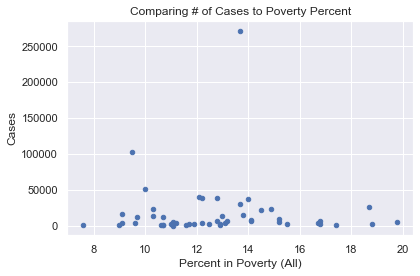

In [20]:
pov_death.plot.scatter("Percent in Poverty (All)","Cases")
plt.title("Comparing # of Cases to Poverty Percent")
plt.tight_layout()
plt.savefig("PNG Folder/PovertyVsCases.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


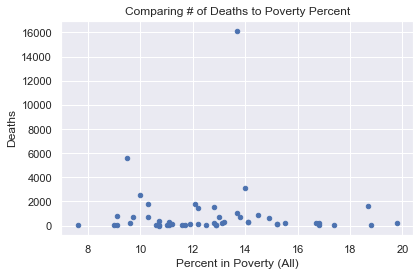

In [21]:
pov_death.plot.scatter("Percent in Poverty (All)","Deaths")
plt.title("Comparing # of Deaths to Poverty Percent")
plt.tight_layout()
plt.savefig("PNG Folder/PovertyVsDeaths.png")



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


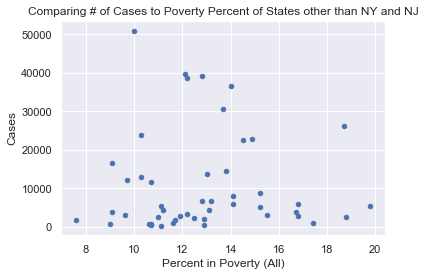

In [22]:
pov_wo_NY = pov_death[(pov_death["State"] != "New York")&(pov_death["State"] !="New Jersey")]
pov_wo_NY.plot.scatter("Percent in Poverty (All)","Cases")
plt.title("Comparing # of Cases to Poverty Percent of States other than NY and NJ")
plt.tight_layout()
plt.savefig("PNG Folder/PovertyVsCaseswoNYNJ.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


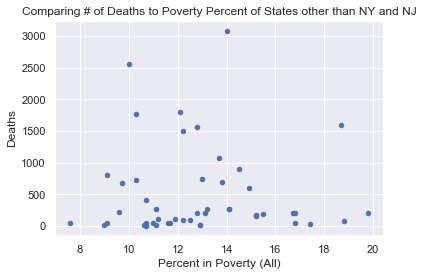

In [23]:
pov_wo_NY = pov_death[(pov_death["State"] != "New York")&(pov_death["State"] !="New Jersey")]
pov_wo_NY.plot.scatter("Percent in Poverty (All)","Deaths")
plt.title("Comparing # of Deaths to Poverty Percent of States other than NY and NJ")
plt.tight_layout()
plt.savefig("PNG Folder/PovertyVsDeathswoNYNJ.png")

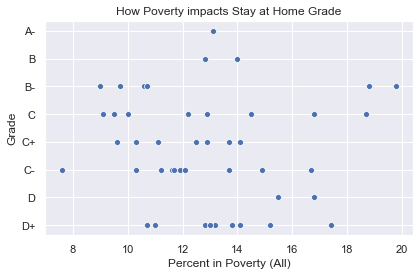

In [24]:
ax= sns.scatterplot(x="Percent in Poverty (All)", y = "Grade",data= grade ).set_title("How Poverty impacts Stay at Home Grade")
plt.tight_layout()
plt.savefig("PNG Folder/Pov_Grade.png")